In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import os
import time
import pickle

from scipy.ndimage import gaussian_filter
import scipy.ndimage as ndimage

from wavefront2d.initialize import *
from wavefront2d.visualize import *
from wavefront2d.benchmark import *
from wavefront2d.patch import *
from wavefront2d.point import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Create 2D IOR field
Input is an image where grey values map to IORs.

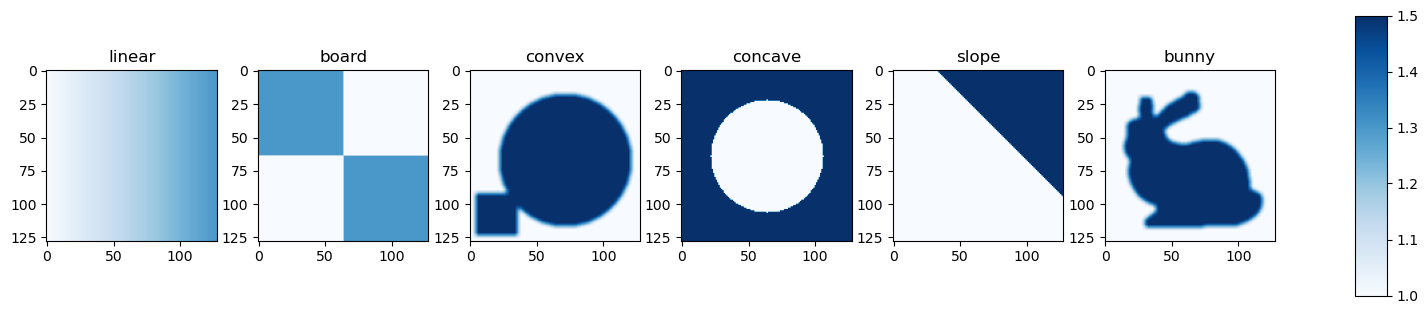

In [24]:
field_size = 128

linear_ior_field = get_ior_field("linear")
board_ior_field = get_ior_field("board")
# convex_ior_field = get_ior_field("convex")
concave_ior_field = get_ior_field("concave")
slope_ior_field = get_ior_field("slope")
steep_slope_ior_field = get_ior_field("steep_slope")
# bunny_ior_field = get_ior_field("bunny")

convex_save_path = os.path.join(os.getcwd(), "wavefront2d", "geometry-2d_ior.npy")
convex_ior_field = np.load(convex_save_path)
bunny_save_path = os.path.join(os.getcwd(), "wavefront2d", "bunny-2d_ior.npy")
bunny_ior_field = np.load(bunny_save_path)

# grad_x, grad_y = compute_gradients(concave_ior_field)
# visualize_gradients(grad_x, grad_y)

visualize_ior_fields([linear_ior_field, board_ior_field, convex_ior_field, concave_ior_field, slope_ior_field, bunny_ior_field],
                      ["linear", "board", "convex", "concave", "slope", "bunny"],)

## 2. Adaptive wavefront propagation

In [25]:
# Initialize wavefront using Points
initial_wavefront_positions = [(float(i), 0.0) for i in range(field_size)]  # initial positions are on the left edge
initial_wavefront_directions = [(0.0, 1.0) for _ in range(field_size)]  # initial directions are all to the right

# Initialize wavefront using Patches
initial_wavefront_patches = init_wavefront_patches(initial_wavefront_positions, initial_wavefront_directions)

num_steps = 1000
delta_t = 0.25

ior_field_dict = {
    # 'board': {'ior': board_ior_field,
    #           'irradiance': None, "mc_irradiance": None},
    'convex_lens': {'ior': convex_ior_field,
                    'irradiance': None, "mc_irradiance": None},
    'bunny' : {'ior': bunny_ior_field,
                'irradiance': None, "mc_irradiance": None},
    # 'concave_lens': {'ior': concave_ior_field, 
    #                  'irradiance': None, "mc_irradiance": None},
}
print(num_steps)

1000


geometry


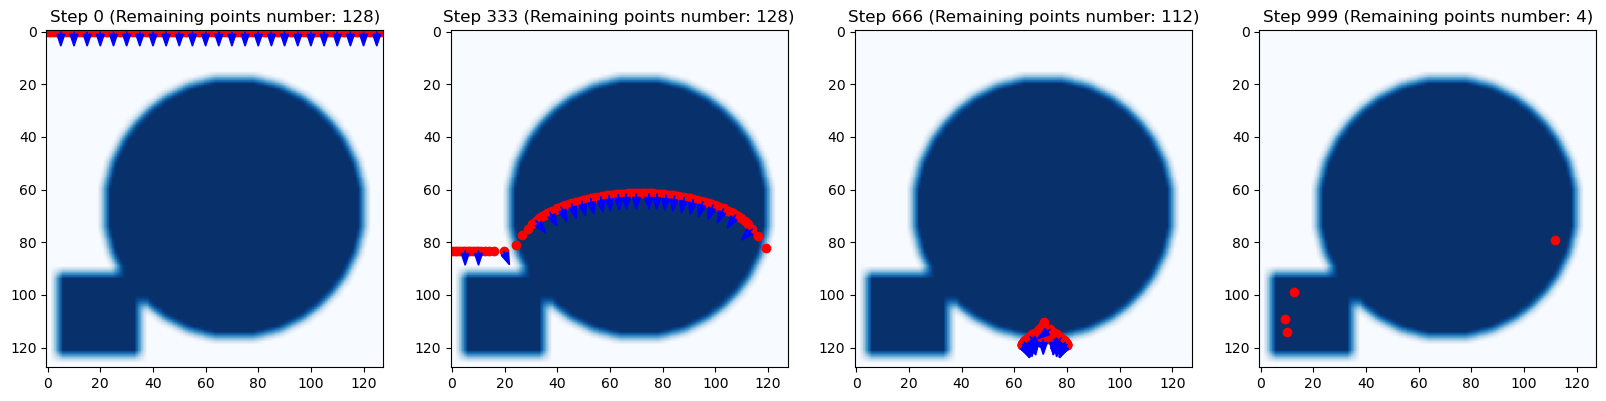

bunny


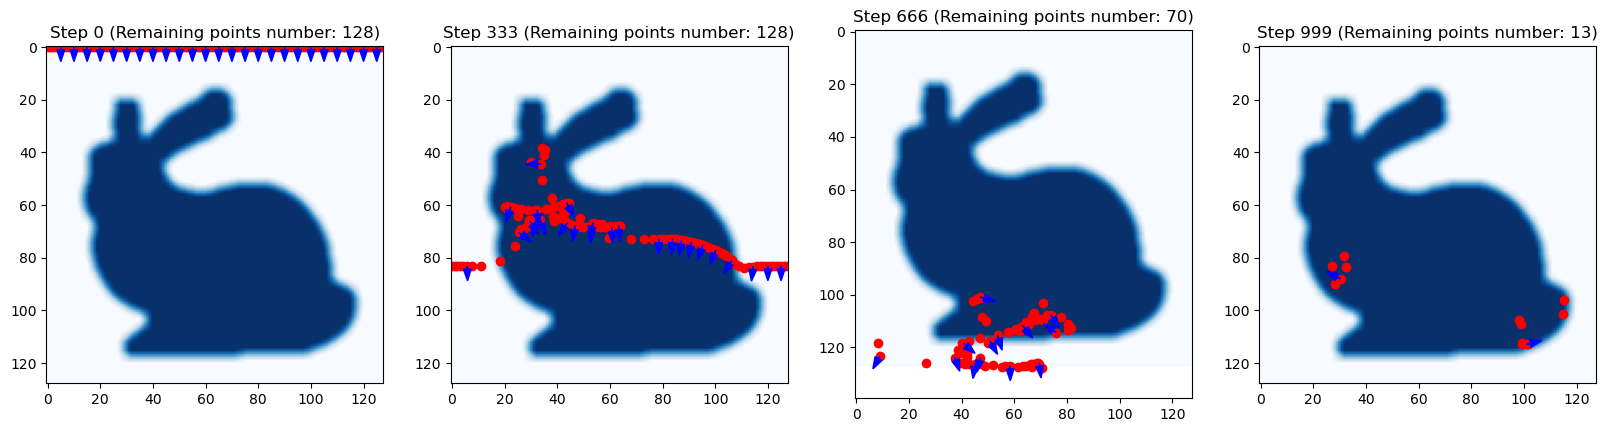

In [26]:
def update_wavefront_points(pos: list[tuple], dir: list[tuple], IOR: np.ndarray, IOR_grad: tuple[np.ndarray, np.ndarray], delta_t: float) -> tuple[list[tuple], list[tuple]]:
    new_pos = []
    new_dir = []
    grad_x_ior, grad_y_ior = IOR_grad
    for (x, y), (vx, vy) in zip(pos, dir):
        if 0 <= int(y) < IOR.shape[0] and 0 <= int(x) < IOR.shape[1]:
            n = IOR[int(y), int(x)]
            
            # x_i+1 = x_i + delta_t * v_i / n^2
            # v_i+1 = v_i + delta_t * grad_n / n
            # calculate the new position
            new_x = x + delta_t * (vx / (n**2))
            new_y = y + delta_t * (vy / (n**2))

            # calculate the new direction
            nx = grad_x_ior[int(y), int(x)]
            ny = grad_y_ior[int(y), int(x)]
            new_vx = vx + delta_t * (nx / n)
            new_vy = vy + delta_t * (ny / n)

            new_pos.append((new_x, new_y))
            new_dir.append((new_vx, new_vy))

        else:
            pass

    return new_pos, new_dir

def simulate_wavefront_propagation_points(cur_IOR: np.ndarray, inital_wavefront_pos: list[tuple], initial_wavefront_dir: list[tuple], 
                                   num_steps=200, delta_t=1.0) -> tuple[list[list[tuple]], list[list[tuple]]]:
    wavefront_pos_list = [inital_wavefront_pos]
    wavefront_dir_list = [initial_wavefront_dir]
    cur_IOR_grad = compute_gradients(cur_IOR)
    for _ in range(num_steps):
        wavefront_positions, wavefront_directions = update_wavefront_points(wavefront_pos_list[-1], wavefront_dir_list[-1], cur_IOR, cur_IOR_grad, delta_t)
        wavefront_pos_list.append(wavefront_positions)
        wavefront_dir_list.append(wavefront_directions)
    return wavefront_pos_list, wavefront_dir_list

def visualize_wavefront_propagation_points(wavefront_pos_list: list[list[tuple]], wavefront_dir_list: list[list[tuple]], 
                                    cur_IOR: np.ndarray, num_show_images, title):
    # show the wavefront propagation in num_show_images steps between 0 and num_steps
    num_show_images = [i for i in range(0, num_steps + 1, num_steps // num_show_images)]

    plt.figure(figsize=(5 * len(num_show_images), 5))
    for i in num_show_images:
        plt.subplot(1, len(num_show_images), num_show_images.index(i) + 1)
        plt.imshow(cur_IOR, cmap='Blues', vmin=1.0, vmax=1.5)
        plt.scatter([p[0] for p in wavefront_pos_list[i]], [p[1] for p in wavefront_pos_list[i]], color='red')
        for j, (x, y) in enumerate(wavefront_pos_list[i]):
            if j != 0 and j % 5 == 0:
                plt.arrow(x, y, wavefront_dir_list[i][j][0], wavefront_dir_list[i][j][1], color='blue', head_width=3)        
        plt.title(f'Step {i} (Remaining points number: {len(wavefront_pos_list[i])})')

    title = title.replace("convex_lens", "geometry")
    print(title)
    save_path = os.path.join(os.getcwd(), "images", f"{title}.png")
    plt.savefig(save_path, dpi=300)
    plt.show()


for key, value in ior_field_dict.items():
    wavefront_pos_list, wavefront_dir_list = simulate_wavefront_propagation_points(value['ior'], initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t)
    value['pos'] = wavefront_pos_list
    value['dir'] = wavefront_dir_list
    visualize_wavefront_propagation_points(wavefront_pos_list, wavefront_dir_list, value['ior'], 3, f"{key}")

## 3. Simulate and Calculate irradiance $\Delta E_{\omega}$

In [27]:
# refine_threshold = 0.8

# # Accumulate irradiance based on patches
# for key, value in ior_field_dict.items():
#     print(f"Processing {key}...")
#     value["irradiance"] = accumulate_patches(value['ior'], initial_wavefront_patches, num_steps, delta_t, refine_threshold)

In [28]:
# num_iterations = 10

# # Accumulate irradiance based on points with Monte Carlo simulations
# for key, value in ior_field_dict.items():
#     print(f"Processing {key}...")
#     value["mc_irradiance"] = accumulate_points_monte_carlo(
#         value['ior'],
#         initial_wavefront_positions,
#         initial_wavefront_directions,
#         num_steps,
#         delta_t,
#         num_simulations=num_iterations,
#         perturbation_std=0.49,
#         field_size=field_size
#     )

In [29]:
GT_THRESHOLD = 0.06
REFINE_THRESHOLDS = [1 - i * 0.01 for i in range(0, 51, 5)]
NUM_ITERATIONS = [i for i in range(10, 51, 5)]

def run_full_benchmark(ior_field_dict, initial_wavefront_patches, initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t, field_size):
    results = {}    
    for scene, ior_data in ior_field_dict.items():
        print(f"Start benchmarking {scene}...")
        results[scene] = {
            'ground_truth': get_ground_truth(GT_THRESHOLD, scene, ior_data, initial_wavefront_patches, num_steps, delta_t, field_size),
            'patches': benchmark_accumulate_patches(REFINE_THRESHOLDS, scene, ior_data, initial_wavefront_patches, num_steps, delta_t, field_size),
            'monte_carlo': benchmark_accumulate_points_monte_carlo(NUM_ITERATIONS, scene, ior_data, initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t, field_size)
        }    
    return results

In [ ]:
# Run full benchmark
# benchmark_results = run_full_benchmark(
#     ior_field_dict,
#     initial_wavefront_patches,
#     initial_wavefront_positions,
#     initial_wavefront_directions,
#     num_steps,
#     delta_t,
#     field_size
# )

In [38]:
# # [to load the results]:
benchmark_results = load_benchmark_results('[0823-2109]bunny_convex_benchmark_results.pkl')

# Or run individual parts:

# benchmark_results["convex_lens"]["monte_carlo"] = benchmark_accumulate_points_monte_carlo(NUM_ITERATIONS, "convex_lens", ior_field_dict["convex_lens"], initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t, field_size)
# benchmark_results["convex_lens"]["patches"] = benchmark_accumulate_patches(REFINE_THRESHOLDS, "convex_lens", ior_field_dict["convex_lens"], initial_wavefront_patches, num_steps, delta_t, field_size)
# benchmark_results["bunny"]["patches"] = benchmark_accumulate_patches(REFINE_THRESHOLDS, "bunny", ior_field_dict["bunny"], initial_wavefront_patches, num_steps, delta_t, field_size)

Benchmark results loaded from [0823-2109]bunny_convex_benchmark_results.pkl


In [ ]:
# # [Save the results]:
# save_benchmark_results(benchmark_results, '[0823-2140]bunny_convex_benchmark_results.pkl')

Analysis for convex_lens:


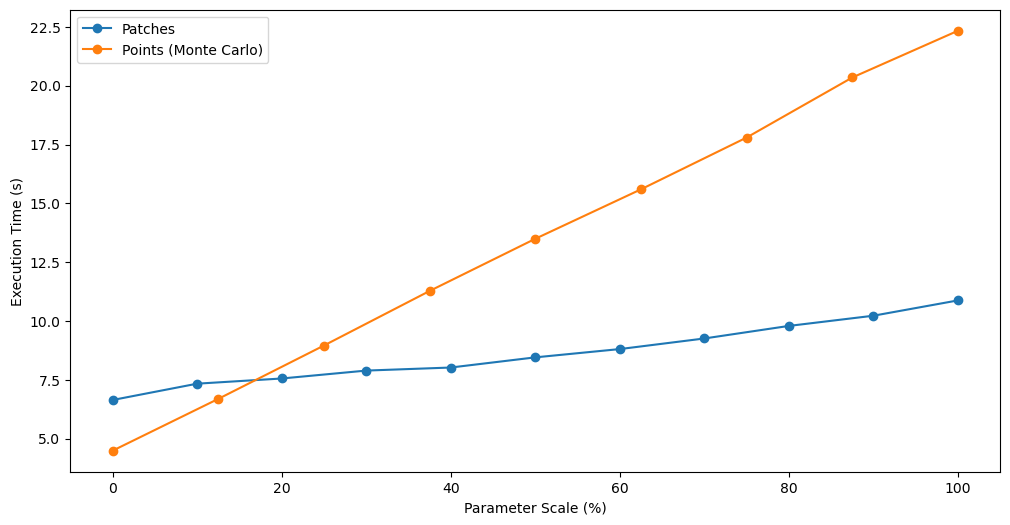

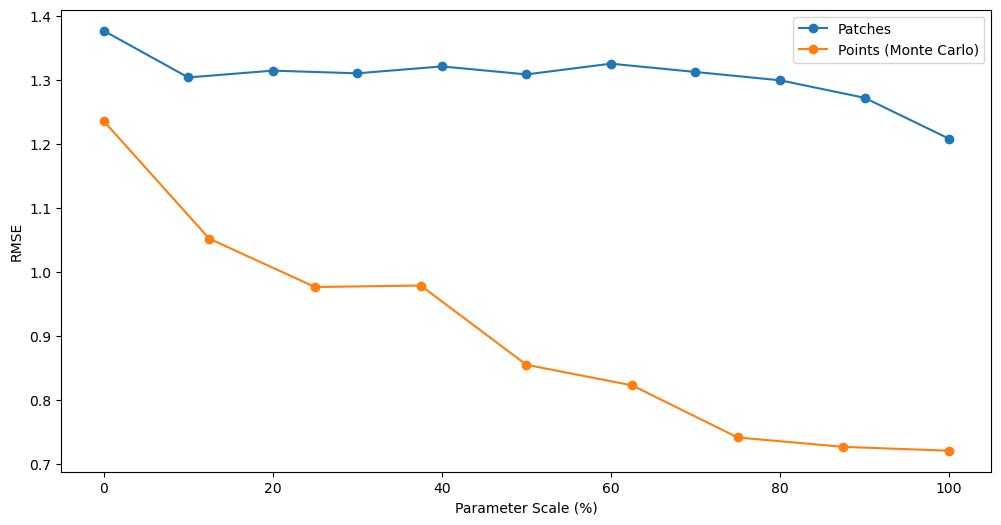

Ground Truth:
  Refine Threshold: 0.06
  Execution Time: 197.0863s

Patches method:
  Min time: 6.6417s (threshold: 1.0)
  Max time: 10.8758s (threshold: 0.6)
  Average time: 8.6237s
  Min RMSE: 1.2087 (threshold: 0.6)
  Max RMSE: 1.3775 (threshold: 1.0)

Monte Carlo method:
  Min time: 4.4867s (iterations: 10)
  Max time: 22.3374s (iterations: 50)
  Average time: 13.4427s
  Min RMSE: 0.7214 (iterations: 50)
  Max RMSE: 1.2364 (iterations: 10)


Analysis for bunny:


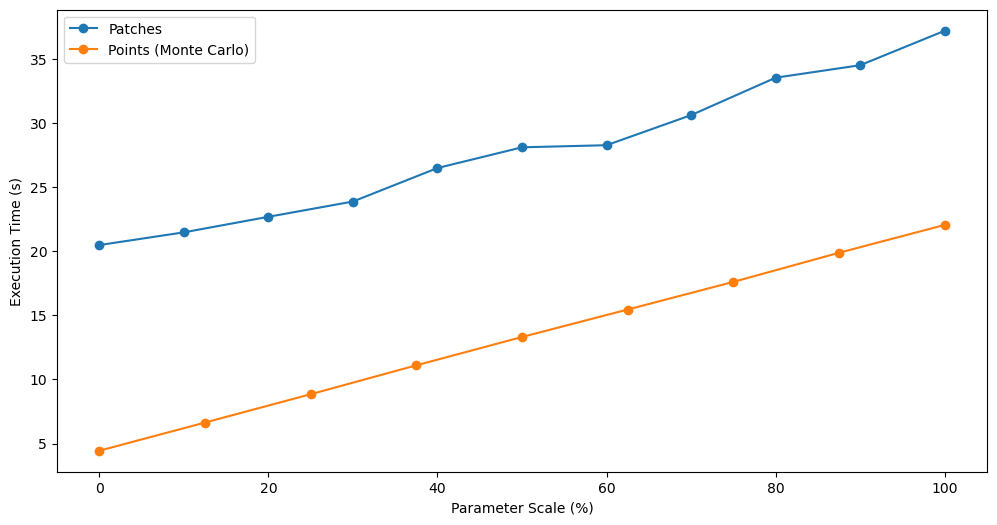

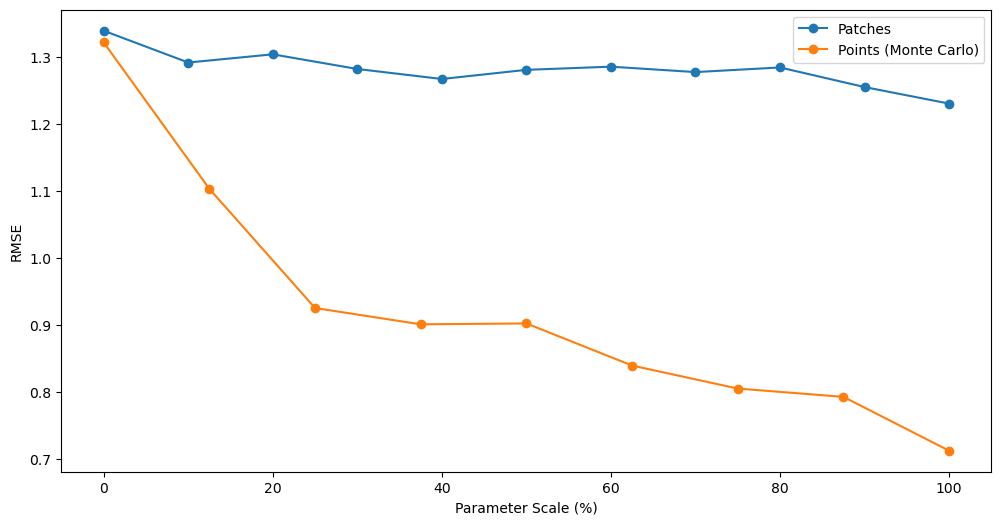

Ground Truth:
  Refine Threshold: 0.06
  Execution Time: 525.4265s

Patches method:
  Min time: 20.4818s (threshold: 1.0)
  Max time: 37.2020s (threshold: 0.6)
  Average time: 27.9329s
  Min RMSE: 1.2306 (threshold: 0.6)
  Max RMSE: 1.3394 (threshold: 1.0)

Monte Carlo method:
  Min time: 4.4389s (iterations: 10)
  Max time: 22.0542s (iterations: 50)
  Average time: 13.2594s
  Min RMSE: 0.7125 (iterations: 50)
  Max RMSE: 1.3220 (iterations: 10)




In [37]:
def calculate_rmse(ground_truth, test_irradiance):
    return np.sqrt(np.mean((ground_truth - test_irradiance) ** 2))

def plot_time_vs_parameter(x, y, title, xlabel, ylabel, invert_x=False):
    plt.figure(figsize=(10, 5))
    plt.plot(x, y, 'o-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if invert_x:
        plt.gca().invert_xaxis()
    plt.show()

def plot_rmse_vs_parameter(x, y, title, xlabel, invert_x=False):
    plot_time_vs_parameter(x, y, title, xlabel, "RMSE", invert_x)

def plot_comparison(patch_percentages, patch_values, mc_percentages, mc_values, title, ylabel):
    plt.figure(figsize=(12, 6))
    plt.plot(patch_percentages, patch_values, 'o-', label='Patches')
    plt.plot(mc_percentages, mc_values, 'o-', label='Points (Monte Carlo)')
    if "convex_lens" in title:
        title = title.replace("convex_lens", "geometry")

    # plt.title(title)
    plt.xlabel("Parameter Scale (%)")
    plt.ylabel(ylabel)
    plt.legend()

    save_path = os.path.join(os.getcwd(), "images", f"{title}.png")
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()
    
def print_summary_statistics(data, method_name):
    times = [result['time'] for result in data]
    rmse_values = [result['rmse'] for result in data]
    parameter_name = 'threshold' if method_name == 'Patches' else 'iterations'
    parameters = [result[f'refine_{parameter_name}' if method_name == 'Patches' else 'num_iterations'] for result in data]

    print(f"\n{method_name} method:")
    print(f"  Min time: {min(times):.4f}s ({parameter_name}: {parameters[times.index(min(times))]})")
    print(f"  Max time: {max(times):.4f}s ({parameter_name}: {parameters[times.index(max(times))]})")
    print(f"  Average time: {sum(times)/len(times):.4f}s")
    print(f"  Min RMSE: {min(rmse_values):.4f} ({parameter_name}: {parameters[rmse_values.index(min(rmse_values))]})")
    print(f"  Max RMSE: {max(rmse_values):.4f} ({parameter_name}: {parameters[rmse_values.index(max(rmse_values))]})")

def analyze_benchmark_results(benchmark_results):
    for scene, data in benchmark_results.items():
        print(f"Analysis for {scene}:")
        ground_truth = data['ground_truth']['irradiance']
        
        # Prepare data
        for method in ['patches', 'monte_carlo']:
            for result in data[method]:
                result['rmse'] = calculate_rmse(ground_truth, result['irradiance'])

        patch_data = data['patches']
        mc_data = data['monte_carlo']

        # Patches method analysis
        patch_thresholds = [result['refine_threshold'] for result in patch_data]
        patch_times = [result['time'] for result in patch_data]
        patch_rmse = [result['rmse'] for result in patch_data]

        # plot_time_vs_parameter(patch_thresholds, patch_times, 
        #                        f"{scene}: Patches Method - Time vs Refine Threshold",
        #                        "Refine Threshold", "Execution Time (s)", invert_x=True)
        # plot_rmse_vs_parameter(patch_thresholds, patch_rmse, 
        #                        f"{scene}: Patches Method - RMSE vs Refine Threshold",
        #                        "Refine Threshold", invert_x=True)

        # Monte Carlo method analysis
        mc_iterations = [result['num_iterations'] for result in mc_data]
        mc_times = [result['time'] for result in mc_data]
        mc_rmse = [result['rmse'] for result in mc_data]

        # plot_time_vs_parameter(mc_iterations, mc_times, 
        #                        f"{scene}: Monte Carlo Method - Time vs Number of Iterations",
        #                        "Number of Iterations", "Execution Time (s)")
        # plot_rmse_vs_parameter(mc_iterations, mc_rmse, 
        #                        f"{scene}: Monte Carlo Method - RMSE vs Number of Iterations",
        #                        "Number of Iterations")

        # Compare both methods
        patch_percentages = [(max(patch_thresholds) - t) / (max(patch_thresholds) - min(patch_thresholds)) * 100 for t in patch_thresholds]
        mc_percentages = [(i - min(mc_iterations)) / (max(mc_iterations) - min(mc_iterations)) * 100 for i in mc_iterations]

        plot_comparison(patch_percentages, patch_times, mc_percentages, mc_times,
                        f"{scene} - Execution Time Comparison", "Execution Time (s)")
        plot_comparison(patch_percentages, patch_rmse, mc_percentages, mc_rmse,
                        f"{scene} - RMSE Comparison", "RMSE")

        # Print summary statistics
        print("Ground Truth:")
        print(f"  Refine Threshold: {data['ground_truth']['refine_threshold']}")
        print(f"  Execution Time: {data['ground_truth']['time']:.4f}s")

        print_summary_statistics(patch_data, "Patches")
        print_summary_statistics(mc_data, "Monte Carlo")
        print("\n")

# Run the analysis
analyze_benchmark_results(benchmark_results)

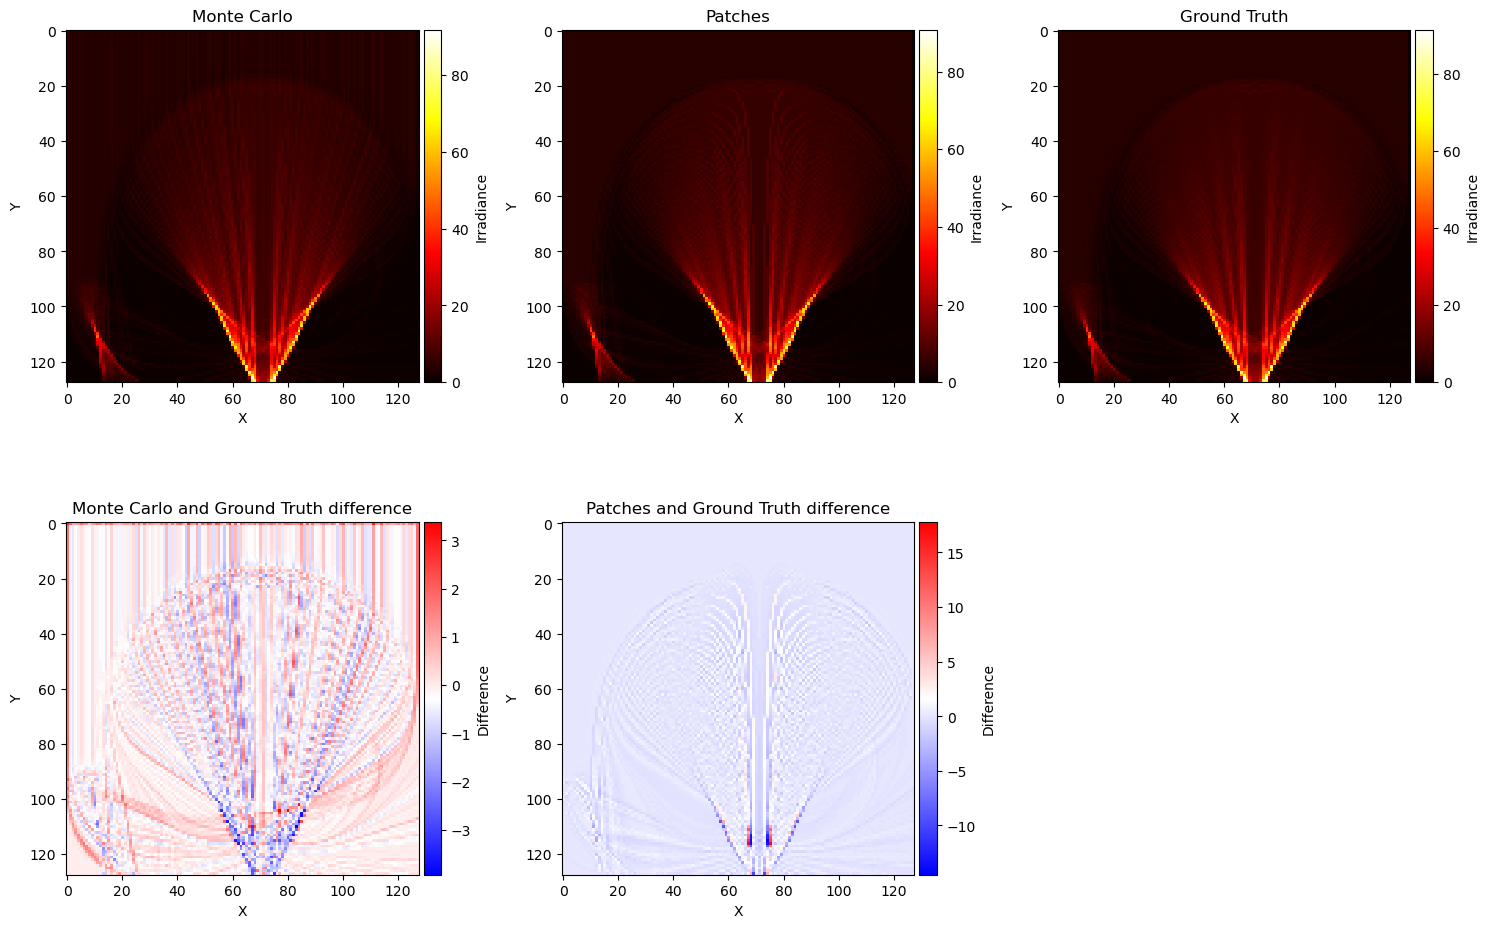

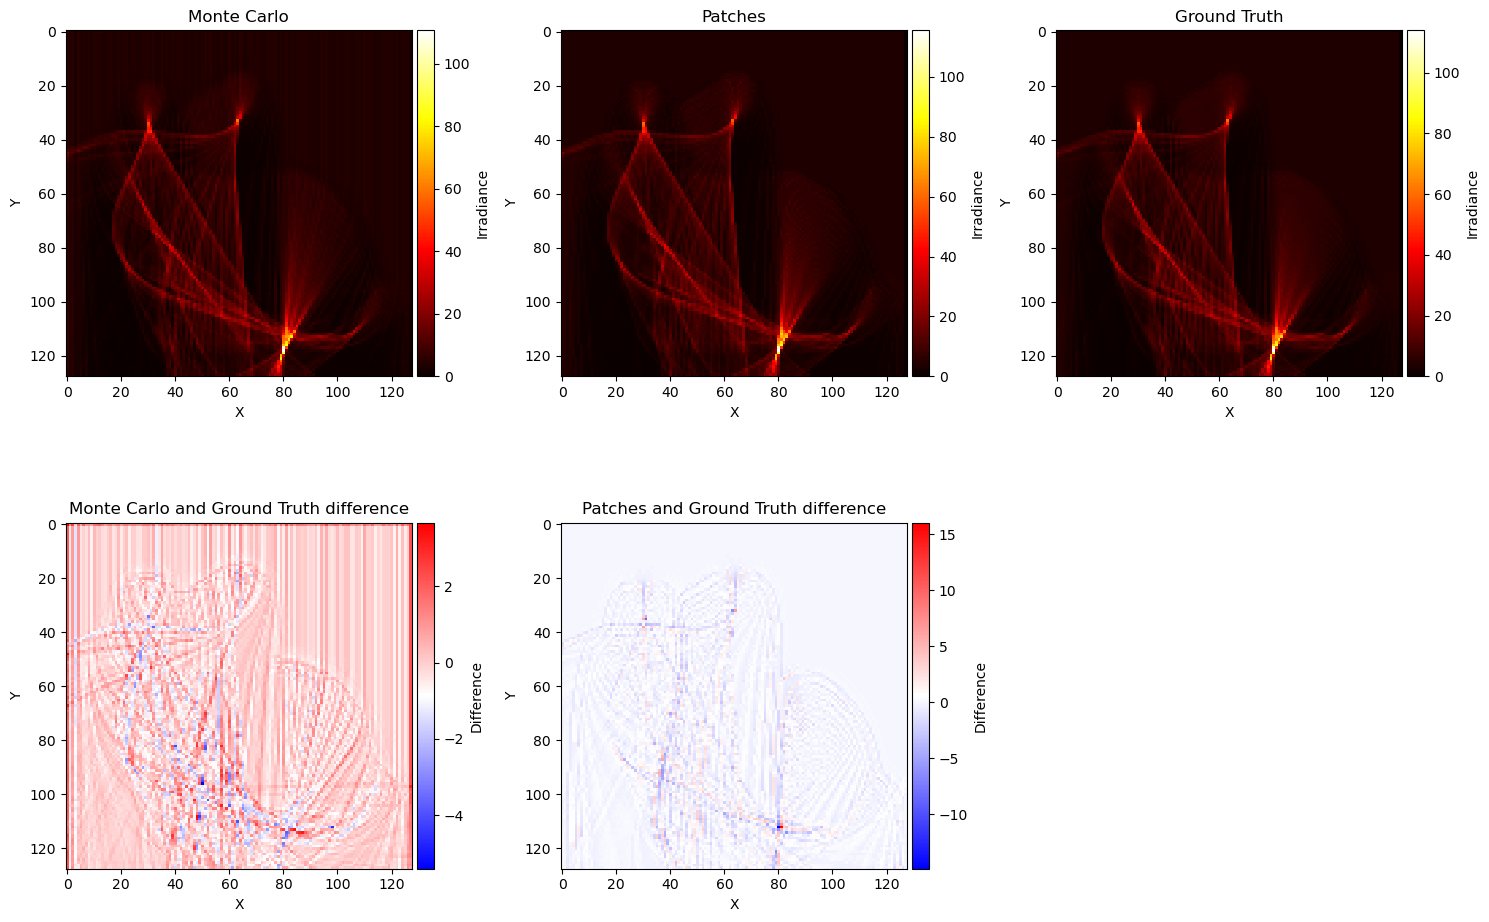

In [49]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_irradiance_comparison(benchmark_results, scene_name):
    # Load data
    point_irrad = benchmark_results[scene_name]["monte_carlo"][-1]["irradiance"]
    patch_irrad = benchmark_results[scene_name]["patches"][-1]["irradiance"]
    data = np.load(f"ground_truth_{scene_name}.npz")
    ground_truth_irradiance = data['irradiance']

    # Create figure
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    # fig.suptitle(f'Irradiance Comparison for {scene_name.capitalize()}', fontsize=16)

    # First row
    titles = ['Monte Carlo', 'Patches', 'Ground Truth']
    images = [point_irrad, patch_irrad, ground_truth_irradiance]
    
    for i, (title, img) in enumerate(zip(titles, images)):
        im = axs[0, i].imshow(img, cmap='hot', interpolation='nearest')
        axs[0, i].set_title(title)
        axs[0, i].set_xlabel('X')
        axs[0, i].set_ylabel('Y')
        
        divider = make_axes_locatable(axs[0, i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax, label="Irradiance")

    # Second row
    diff_titles = ['Monte Carlo and Ground Truth difference', 'Patches and Ground Truth difference']
    diff_images = [point_irrad - ground_truth_irradiance, 
                   patch_irrad - ground_truth_irradiance]
    
    for i, (title, img) in enumerate(zip(diff_titles, diff_images)):
        im = axs[1, i].imshow(img, cmap='bwr', interpolation='nearest')
        axs[1, i].set_title(title)
        axs[1, i].set_xlabel('X')
        axs[1, i].set_ylabel('Y')
        
        divider = make_axes_locatable(axs[1, i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax, label="Difference")

    # Remove the last subplot in the second row
    fig.delaxes(axs[1, 2])

    # Adjust layout and save
    plt.tight_layout()
    save_path = os.path.join(os.getcwd(), "images", f"{scene_name}_comparison.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Usage
visualize_irradiance_comparison(benchmark_results, "convex_lens")
visualize_irradiance_comparison(benchmark_results, "bunny")

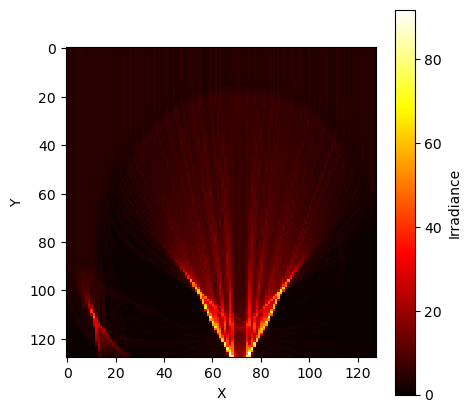

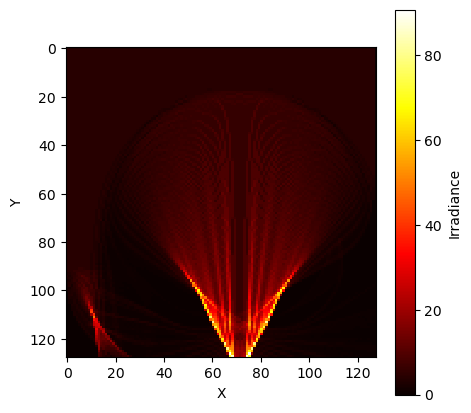

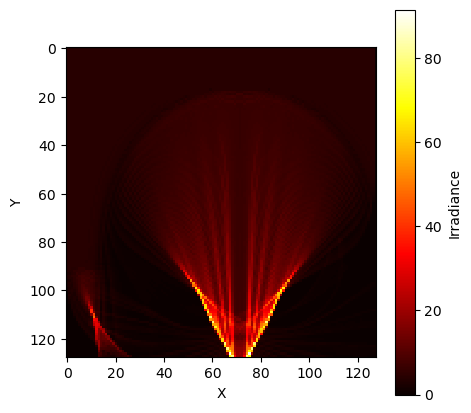

In [41]:
def visualize_irradiance(irradiance: np.ndarray, title: str = "Irradiance"):
    plt.figure(figsize=(5, 5))
    plt.imshow(irradiance, cmap='hot', interpolation='nearest')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(label="Irradiance")
    save_path = os.path.join(os.getcwd(), "images", f"{title}.png")
    plt.savefig(save_path, dpi=300)
    plt.show()

geometry_point_irrad = benchmark_results["convex_lens"]["monte_carlo"][-1]["irradiance"]
visualize_irradiance(geometry_point_irrad, "Monte Carlo (50 iterations, geometry)")

geometry_patch_irrad = benchmark_results["convex_lens"]["patches"][-1]["irradiance"]
visualize_irradiance(geometry_patch_irrad, "Patches (0.5, geometry)")

data = np.load(f"ground_truth_convex_lens.npz")
ground_truth_irradiance = data['irradiance']
visualize_irradiance(ground_truth_irradiance, "Ground Truth (geometry)")

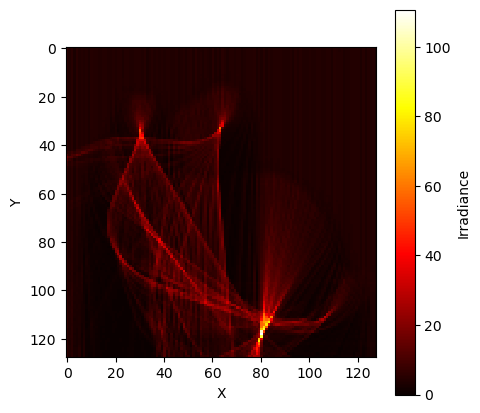

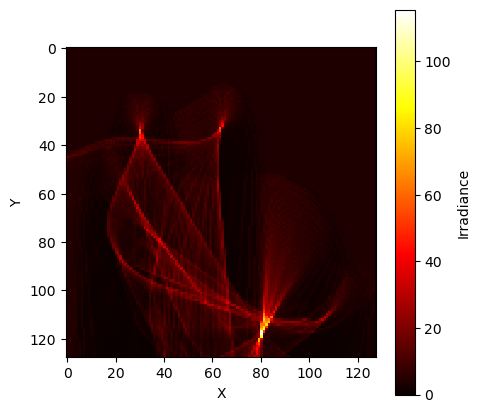

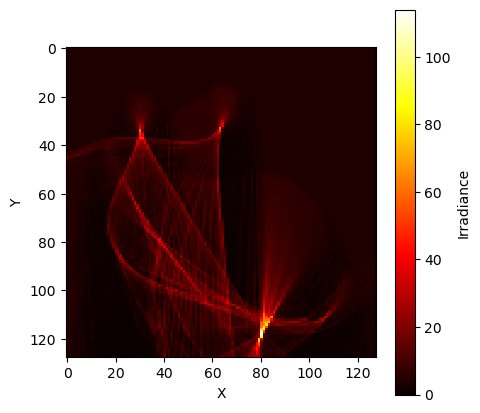

In [42]:
bunny_point_irrad = benchmark_results["bunny"]["monte_carlo"][-1]["irradiance"]
visualize_irradiance(bunny_point_irrad, "Monte Carlo (50 iterations, bunny)")

bunny_patch_irrad = benchmark_results["bunny"]["patches"][-1]["irradiance"]
visualize_irradiance(bunny_patch_irrad, "Patches (0.5, bunny)")

data = np.load(f"ground_truth_bunny.npz")
ground_truth_irradiance = data['irradiance']
visualize_irradiance(ground_truth_irradiance, "Ground Truth (bunny)")

In [ ]:
# for key, value in ior_field_dict.items():
#     value["simp_irradiance"] = accumulate_points(value['ior'], initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t)

# print("Irradiance computation done")

# for key, value in ior_field_dict.items():
#     simple_irradiance = value["mc_irradiance"]
#     patches_irradiance = value["irradiance"]
#     visualize_compare_irradiance(simple_irradiance, patches_irradiance, f"Irradiance comparison for {key}")

## 4. Store irradiance into quad tree

In [ ]:
tester = "convex_lens"
test_irradiance = ior_field_dict[tester]['irradiance']

In [ ]:
class Node:
    def __init__(self, val: int = 0, top_left=None, top_right=None, bottom_left=None, bottom_right=None):
        self.val = val
        self.top_left = top_left
        self.top_right = top_right
        self.bottom_left = bottom_left
        self.bottom_right = bottom_right
    
    @property
    def is_leaf(self):
        return all(child is None for child in (self.top_left, self.top_right, self.bottom_left, self.bottom_right))
    
    def __repr__(self):
        return self._repr_recursive()

    def _repr_recursive(self, depth=0, max_depth=2):
        indent = "  " * depth
        if self.is_leaf:
            return f"{indent}Node(val={self.val})"
        else:
            if depth >= max_depth:
                return f"{indent}Node(...)"
            children_repr = ",\n".join(self._repr_recursive_child(child, depth + 1, max_depth) for child in 
                                       (self.top_left, self.top_right, self.bottom_left, self.bottom_right))
            return f"{indent}Node(\n{children_repr})"

    def _repr_recursive_child(self, child, depth, max_depth):
        return "  " * depth + "None" if child is None else child._repr_recursive(depth, max_depth)

class QuadTree:
    def __init__(self, threshold: int = 0):
        self.threshold = threshold
        self.grid_size = 0
        self.root = None
    
    def construct(self, grid: np.ndarray) -> None:
        self.root = self._build_tree(grid, 0, 0, grid.shape[0])
        self.grid_size = grid.shape[0]
    
    def _build_tree(self, grid: np.ndarray, i: int, j: int, size: int) -> Node:
        if self._is_homogeneous(grid, i, j, size):
            return Node(grid[i, j])

        half_size = size // 2
        top_left = self._build_tree(grid, i, j, half_size)
        top_right = self._build_tree(grid, i, j + half_size, half_size)
        bottom_left = self._build_tree(grid, i + half_size, j, half_size)
        bottom_right = self._build_tree(grid, i + half_size, j + half_size, half_size)
        
        if top_left.is_leaf and top_right.is_leaf and bottom_left.is_leaf and bottom_right.is_leaf:
            values = {node.val for node in (top_left, top_right, bottom_left, bottom_right)}
            if len(values) == 1:
                return Node(values.pop())
        
        return Node(top_left=top_left, top_right=top_right, bottom_left=bottom_left, bottom_right=bottom_right)
    
    def _is_homogeneous(self, grid: np.ndarray, i: int, j: int, size: int) -> bool:
        return np.ptp(grid[i:i+size, j:j+size]) <= self.threshold

    def query(self, x: int, y: int) -> int:
        return self._query(self.root, 0, 0, self.grid_size, x, y)

    def _query(self, node: Node | None, i: int, j: int, size: int, x: int, y: int) -> int:
        if node is None:
            raise ValueError("QuadTree is empty. Maybe you forgot to construct it?")
        
        if node.is_leaf:
            return node.val

        half_size = size // 2
        if x < i + half_size:
            if y < j + half_size:
                return self._query(node.bottom_left, i, j, half_size, x, y)
            else:
                return self._query(node.top_left, i, j + half_size, half_size, x, y)
        else:
            if y < j + half_size:
                return self._query(node.bottom_right, i + half_size, j, half_size, x, y)
            else:
                return self._query(node.top_right, i + half_size, j + half_size, half_size, x, y)
    
    def __len__(self):
        return self._count_nodes(self.root)
    
    def _count_nodes(self, node: Node | None) -> int:
        if node is None:
            return 0
        return 1 + sum(self._count_nodes(child) for child in 
                       (node.top_left, node.top_right, node.bottom_left, node.bottom_right))
    
    def __sizeof__(self):
        return self._calculate_memory_usage(self.root)
    
    def _calculate_memory_usage(self, node: Node | None) -> int:
        if node is None:
            return 0
        return sys.getsizeof(node) + sum(self._calculate_memory_usage(child) for child in 
                                         (node.top_left, node.top_right, node.bottom_left, node.bottom_right))
    
    def visualize(self, figsize=(20, 20)):
        plt.figure(figsize=figsize)
        self._visualize_node(self.root, 0, 0, self.grid_size)
        plt.axis('equal')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.tight_layout()
        plt.title('Quad Tree Visualization')
        plt.show()
        
    def _visualize_node(self, node: Node | None, x: float, y: float, size: float):
        if node is None:
            return
        if node.is_leaf:
            rect = patches.Rectangle((x, y), size, size, linewidth=1, edgecolor='black', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x + size / 2, y + size / 2, str(int(node.val)), ha='center', va='center', fontsize=8)
        else:
            half_size = size / 2
            self._visualize_node(node.top_left, x, y + half_size, half_size)
            self._visualize_node(node.top_right, x + half_size, y + half_size, half_size)
            self._visualize_node(node.bottom_left, x, y, half_size)
            self._visualize_node(node.bottom_right, x + half_size, y, half_size)



quad_tree = QuadTree(threshold=4) 
quad_tree.construct(test_irradiance)

value = quad_tree.query(60, 60)
print(f"Query value at (0, 99): {value}")

node_count = len(quad_tree)
print(f"Number of nodes: {node_count}")

memory_usage = sys.getsizeof(quad_tree)
print(f"Memory Usage: {memory_usage} bytes")
print(f"In comparison, NumPy Storage Usage: {test_irradiance.nbytes} bytes")

quad_tree.visualize()

In [ ]:
# plt show test_irradiance and write its each element specific int value
plt.figure(figsize=(20, 20))
plt.imshow(test_irradiance, cmap='hot', interpolation='nearest')
for i in range(test_irradiance.shape[0]):
    for j in range(test_irradiance.shape[1]):
        plt.text(j, i, str(int(test_irradiance[i, j])), ha='center', va='center', color='black', fontsize=7)
plt.colorbar(label='Irradiance')
plt.title('Test Irradiance')
plt.show()